<a href="https://colab.research.google.com/github/hanyoung-r/-/blob/master/final_code%ED%95%9C%EC%98%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. 라이브러리**

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt                                                                                                                   

import keras
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, UpSampling2D, Input, Convolution2D, Reshape,Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import keras.backend as K


print(tf.__version__)

Using TensorFlow backend.


2.2.0


**2. 파일 불러오기**

In [0]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file:"{name}"with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving all1.csv to all1.csv
User uploaded file:"all1.csv"with length 14650569 bytes


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**3. csv파일 numpy 형태로 변경**

In [0]:
csv_data = pd.read_csv('all1.csv', header=None) #전처리 된 all1파일을 불러와서 csv_data로 저장
print(csv_data)

dataset = np.array(csv_data) #csv_data를 array형태로 변환

np.save('datasetreal', dataset) #위의 과정을 실행한 dataset을 datasetreal이라고 저장

dataset_2 = np.load('datasetreal.npy',allow_pickle=True) #텍스트 이외의 자료형을 저장하기 위해pickle

np.shape(dataset_2)



       0    1    2    3    4    5    6    ...  618  619  620  621  622  623  624
0        0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
1        0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
2        0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
3        0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
4        0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
11707    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
11708    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
11709    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
11710    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0
11711    0    0    0    0    0    0    0  ...    0    0    0    0    0    0    0

[11712 rows x 625 columns]


(11712, 625)

**4. data shape**

In [0]:
train_dataset = dataset_2 #dataset_2를 train_dataset으로 불러옴

print("Train shape: ", np.shape(dataset_2)) #dataset_2의 크기 출력

start_train = dataset_2[:,:] #행전체, 열전체구간을 가져와서사용


Train shape:  (11712, 625)


**5. Setting a num_row Parameters**

In [0]:
num_row = 11712
num_row

11712

In [0]:
LAG = 4 #input값으로 묶을 개수
STEP = 1
BIAS = 0 #몇칸 뜨고 시작할지

**6. def sampler function**

In [0]:
def sampler(data, lag=4, bias=0, step=1, temp=False):
    """This function makes samples of the time series data
    args:
    - data : (# of data, height, width)
    - lag : the length of sampling
    - step : (step)-ahead forecasting label
    return: 
    - data_x (# of sample, height, width, lag)
    - data_y (# of sample, height, width, 1)
    """
    #num_row = len(data)
    data_x, data_y = [], [] #배열 선언
    for idx in range(num_row): #idx부터 num_row(11712)까지 1씩 더하면서 실행
        strat_idx = idx + bias
        try:
            y = np.array(data[strat_idx+lag+(step-1),:]) #strat_idx에 lag 더한 번호가 y data
            
            data_y.append(y) #구한 y를 data_y로 명명
            
            if not temp:
                x = np.transpose(data[strat_idx:strat_idx+lag,:]) #strat_idx번째부터 lag 만큼을 x

                data_x.append(x) #구한 x를 data_x로 명명
        except:  #예외가 발생함
           # if len(np.shape(data_y)) <4 and not temp: #data_y의 길이가 4이하면 
            #    data_y = np.expand_dims(data_y, axis=-1) #마지막 axis를 확장시킴              
                                
            print("Sampler Return", np.shape(data_x), np.shape(data_y))
            break
            
    if not temp:
        return np.array(data_x), np.array(data_y)
    else:
        return np.array(data_y)

In [0]:
train_x, train_y = sampler(start_train, lag=LAG, bias=BIAS, step=STEP) #위 함수에 data,lag=4,bias,step 대입


Sampler Return (11708, 625, 4) (11708, 625)


In [0]:
datax = train_x.reshape(11708,25,25,4)
datay = train_y.reshape(11708,25,25,1) #data_x와 data_y의 크기를 reshape

**7. 4개 1개로 나눈 데이터 numpy 형태로 저장**

In [0]:
print(datax)

**8. 데이터 정규화 및 CAE hyperparameter 설정**

In [0]:
X=datax/160 #x와 y를 0~1사이로 정규화
Y=datay/160


# hyper parameter 설정
img_size = 25       # 이미지 사이즈
latent_dim = 32    # latent dimension 크기 설정


In [0]:
#test퍼센트
pertest= 0.15
#valid퍼센트
pervalid = 0.15
#나눌값
traintovalid = pervalid / (1-pertest)

In [0]:
# Train set(80%), Test set(20%)으로 나누기 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=pertest, shuffle= False) 
#셔플(순서섞기) x
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
print(np.shape(Y_test))

(9951, 25, 25, 4)
(9951, 25, 25, 1)
(1757, 25, 25, 4)
(1757, 25, 25, 1)


In [0]:
# Train set(80%), Test set(20%)으로 나누기 
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train,Y_train, test_size = traintovalid, shuffle= False)
#셔플(순서섞기)x
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_valid))
print(np.shape(Y_valid))

(8194, 25, 25, 4)
(8194, 25, 25, 1)
(1757, 25, 25, 4)
(1757, 25, 25, 1)


**9. model 설정**

In [0]:
# 인코더
def encoder():

  model = tf.keras.Sequential()
  model.add(Conv2D(5, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 4)))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(10, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(15, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(20, (3, 3), activation='relu', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(25, (3, 3), activation='relu', padding='same'))
  model.add(Flatten())
  # latent dimension으로 축소됨
  model.add(Dense(latent_dim)) 

  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 5)         185       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 10)        460       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 10)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 15)          1365      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 15)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 20)          2

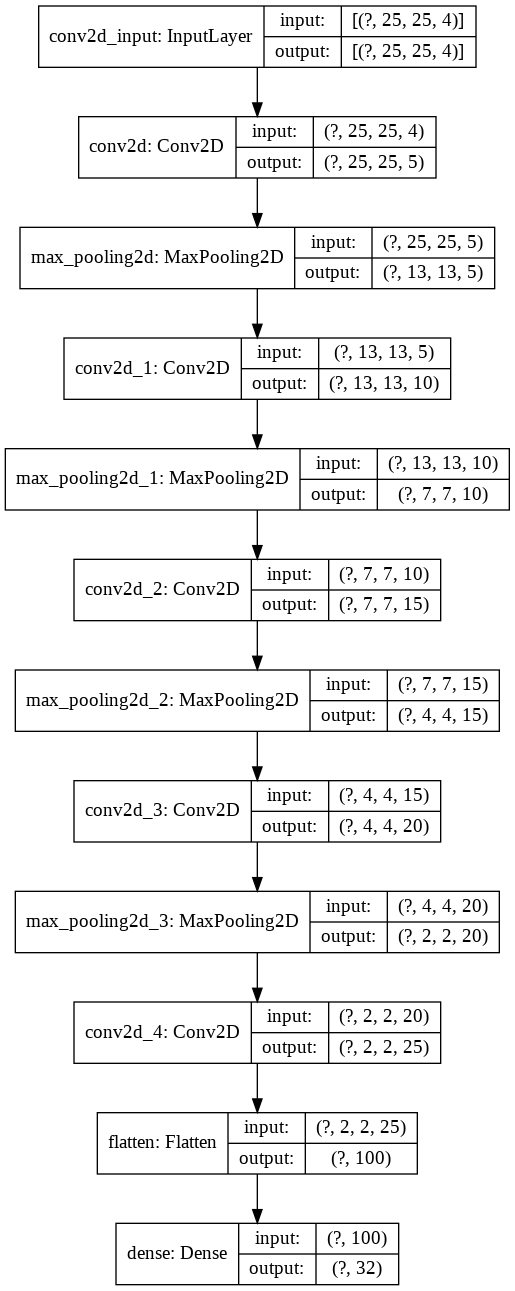

In [0]:
# 인코더 함수를 실행해서 모델을 build 후 변수에 집어넣고, 모델 구조를 살펴봄
e_model = encoder()
e_model.summary()
plot_model(e_model, show_shapes=True)

In [0]:
# 디코더
def decoder():

  model = tf.keras.Sequential()
  model.add(Dense(2 * 2 * 25, input_shape=(latent_dim,)))
  model.add(Reshape((2 ,2, 25)))
  model.add(Conv2D(25, (2, 2), activation='relu', padding=('same')))
  model.add(UpSampling2D((2, 2)))
  model.add(Conv2D(25, (2, 2), activation='relu', padding=('same')))
  model.add(UpSampling2D((2, 2)))
  model.add(Cropping2D(cropping=((1, 0), (1, 0)), data_format=None))
  model.add(Conv2D(25, (2, 2), activation='relu', padding='same'))
  model.add(UpSampling2D((2, 2)))
  model.add(Cropping2D(cropping=((1, 0), (1, 0)), data_format=None))
  model.add(Conv2D(25, (2, 2), activation='relu', padding=('same')))
  model.add(UpSampling2D((2, 2)))
  model.add(Cropping2D(cropping=((1, 0), (1, 0)), data_format=None))
  model.add(Conv2D(25, (2, 2), activation='relu', padding=('same')))

  model.add(Dropout(0.5))
  model.add(Conv2D(1, (2, 2), padding='same'))
 
  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               3300      
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 25)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 25)          2525      
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 4, 4, 25)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 25)          2525      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 25)          0         
_________________________________________________________________
cropping2d (Cropping2D)      (None, 7, 7, 25)         

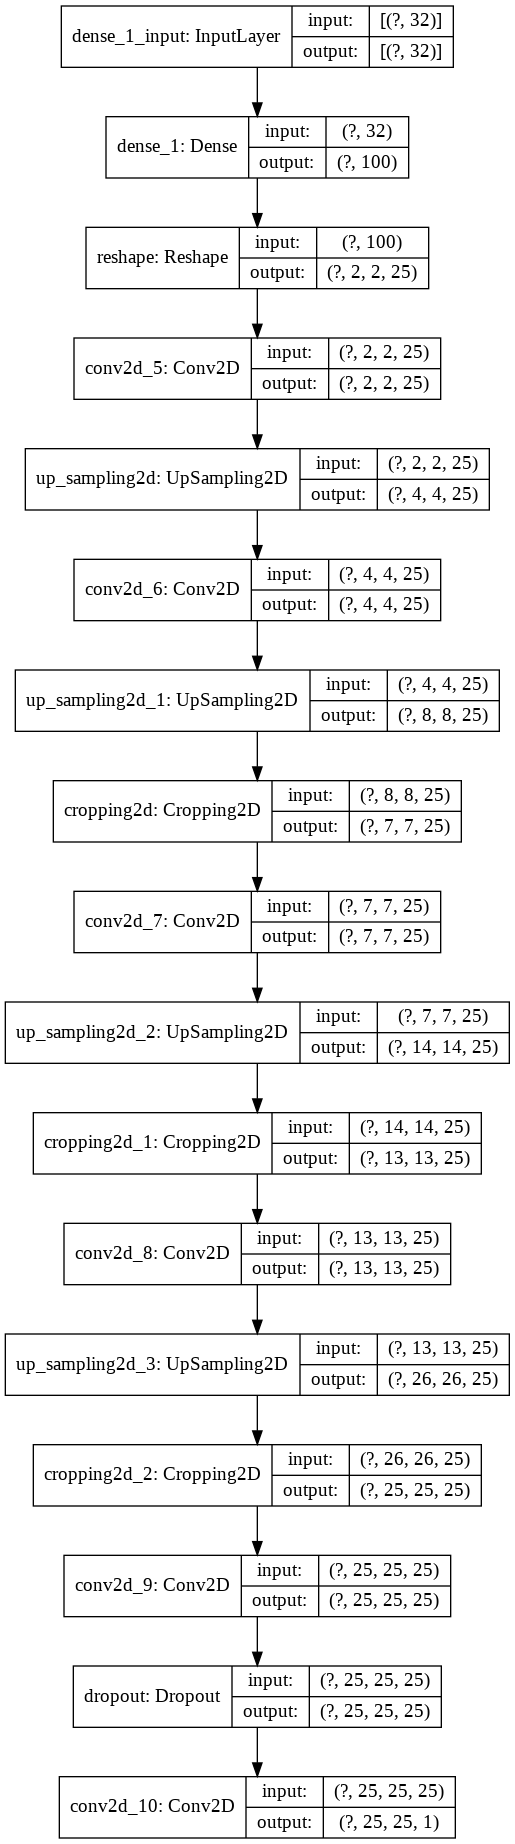

In [0]:
# 디코더 함수를 실행해서 모델을 build 후 변수에 집어넣고, 모델 구조를 살펴봄
d_model = decoder()
d_model.summary()
plot_model(d_model, show_shapes=True)

In [0]:
# loss function rmse 정의
def rmse (y_true, y_pred):  # RMSE : root mean square error
  return K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))  #예측값과 실제값의 차이 제곱의 평균

# loss function mape 정의
def mape (y_true, y_pred):  # RMSE : root mean square (error)
  rtn = K.mean(K.abs((y_true - y_pred) / (1.0 + y_true)))  #실제값+1에대한 예측값과 실제값 차이의 비율
  return rtn

In [0]:
# 모델을 합쳐줌 
input_img = Input(shape=(img_size, img_size, 4)) #input형태
model = Model(input_img, d_model(e_model(input_img)), name='autoencoder') #input를 encoder->decoder순으로 처리

# CNN 모델 구조 확정하고 컴파일 진행

adam=Adam(lr=0.00008, beta_1=0.9) #

model.compile(optimizer=adam,
              loss='mean_squared_error', 
              metrics=[rmse,mape])   #optimizer로 adam이용, loss값은 rmse와 mape이용

In [0]:
# model.fit을 써서 학습. 학습과정을 history에 저장
history = model.fit(X_train, Y_train,
                    batch_size=30,
                    epochs=700,
                    verbose=2,
                    validation_data=(X_valid, Y_valid),
                    shuffle=False)
# X train input, Y train 라벨값


Epoch 1/700
274/274 - 2s - loss: 4.2488e-05 - rmse: 0.0032 - mape: 0.0031 - val_loss: 3.6298e-05 - val_rmse: 0.0029 - val_mape: 0.0029
Epoch 2/700
274/274 - 2s - loss: 3.9128e-05 - rmse: 0.0030 - mape: 0.0030 - val_loss: 3.3989e-05 - val_rmse: 0.0028 - val_mape: 0.0028
Epoch 3/700
274/274 - 2s - loss: 3.7199e-05 - rmse: 0.0029 - mape: 0.0029 - val_loss: 3.2547e-05 - val_rmse: 0.0027 - val_mape: 0.0027
Epoch 4/700
274/274 - 2s - loss: 3.6110e-05 - rmse: 0.0028 - mape: 0.0028 - val_loss: 3.1643e-05 - val_rmse: 0.0026 - val_mape: 0.0026
Epoch 5/700
274/274 - 2s - loss: 3.5272e-05 - rmse: 0.0028 - mape: 0.0027 - val_loss: 3.0800e-05 - val_rmse: 0.0026 - val_mape: 0.0026
Epoch 6/700
274/274 - 2s - loss: 3.4483e-05 - rmse: 0.0027 - mape: 0.0027 - val_loss: 3.0005e-05 - val_rmse: 0.0026 - val_mape: 0.0026
Epoch 7/700
274/274 - 2s - loss: 3.3772e-05 - rmse: 0.0027 - mape: 0.0027 - val_loss: 2.9312e-05 - val_rmse: 0.0025 - val_mape: 0.0025
Epoch 8/700
274/274 - 2s - loss: 3.3027e-05 - rmse: 0.0

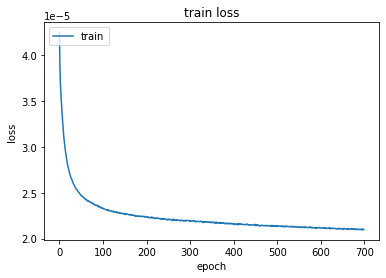

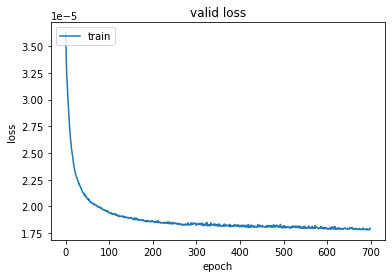

In [0]:
 #loss값의 변화 추출
 # Train data의 loss
plt.plot(history.history['loss'])
plt.title('train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Validation data의 loss
plt.plot(history.history['val_loss'])
plt.title('valid loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
# test 값 결과 확인
score = model.evaluate(X_test, Y_test, verbose=0) # verbose가 0 이면 ==== 움직이지 않고, 1이면 ==== 진행 바가 움직임
print('Test loss(rmse) :', score[1])
print('Test loss(mape) :', score[2])


Test loss(rmse) : 0.0014346042880788445
Test loss(mape) : 0.0014227022184059024


[csv저장]

In [0]:
#n번째 데이터 뽑을거니
n = 10

In [0]:
sample1 = X_test[n]
np.shape(sample1)

(25, 25, 4)

In [0]:
prediction = model.predict(X_test)  
predsample = Y_test[n]
np.shape(predsample)
sam1 = np.reshape([predsample],(25,25))
sam1 = pd.DataFrame(sam1)
sam1 = sam1 * 160
sam1.to_csv('predicted.csv', index=False, encoding='cp949')
files.download('predicted.csv')